# <span style="color:red">Análisis de datos en Python</span>


> Adrián Felipe Hernández Borda
>

>
> Universidad Pedagógica y Tecnológica de Colombia $\Big[\text{UPTC}\Big]$
>
> Universidad Autónoma de Sinaloa $\Big[\text{UAS}\Big]$
>



El presente es un cuaderno de trabajo, pruebas y avances sobre el proyecto desarrollado en la **optativa de análisis de datos en python**
## <span style="color:rgb(0,180,200)">Objetivos</span>

> Determinar las classes que afectan más a las calificaciones en exámenes de (***Matemática, Escritura y Lectura***)

> Entrenar un modelo capaz de predecir las calificaciones de unos estudiantes en pruebas de: (***Matemática, Escritura y Lectura***); con base a algunas características de su entorno académico, familiar y vida personal.

---
# <span style="color:rgb(180,200,0)">Importar librerías</span>

---


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn as sk
sns.set_style(style="ticks")
from os import cpu_count as ncpu
from multiprocessing import Pool as pool
from fitter import Fitter as ftr

import warnings
warnings.filterwarnings('ignore') 

#%matplotlib widget

---
## <span style="color:rgb(180,200,0)">Importar datos</span>

---
Se importa el `csv` con la base de datos con la ruta del archivo.

In [2]:
path = "./datasets/"

file = "Expanded_data_with_more_features.csv"

full_path = path+file

print(f"Dirección del conjunto de datos: '{full_path:s}'")


Dirección del conjunto de datos: './datasets/Expanded_data_with_more_features.csv'


In [3]:
data = pd.read_csv(full_path,sep=",")

data = data.drop(labels='ID',axis=1)
sz = data.shape
print(f"Número de variables -> {sz[0]}\nEntradas del conjunto de datos -> {sz[1]}")

print("\n--- CABECERA DEL CONJUNTO DE DATOS ---\n")
display(data.head())

print("\n--- DESCRIPCIÓN ---\n")
display(data.info())

Número de variables -> 30641
Entradas del conjunto de datos -> 14

--- CABECERA DEL CONJUNTO DE DATOS ---



,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,female,NaN,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,< 5,71,71,74
1,female,group C,some college,standard,NaN,married,sometimes,yes,0.0,NaN,5 - 10,69,90,88
2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5,87,93,91
3,male,group A,associate's degree,free/reduced,none,married,never,no,1.0,NaN,5 - 10,45,56,42
4,male,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,76,78,75



--- DESCRIPCIÓN ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gender               30641 non-null  object 
 1   EthnicGroup          28801 non-null  object 
 2   ParentEduc           28796 non-null  object 
 3   LunchType            30641 non-null  object 
 4   TestPrep             28811 non-null  object 
 5   ParentMaritalStatus  29451 non-null  object 
 6   PracticeSport        30010 non-null  object 
 7   IsFirstChild         29737 non-null  object 
 8   NrSiblings           29069 non-null  float64
 9   TransportMeans       27507 non-null  object 
 10  WklyStudyHours       29686 non-null  object 
 11  MathScore            30641 non-null  int64  
 12  ReadingScore         30641 non-null  int64  
 13  WritingScore         30641 non-null  int64  
dtypes: float64(1), int64(3), object(10)
memory usage: 3.3+ MB


None


# <span style="color:rgb(180,200,0)">Descripción del conjunto de datos</span>


Lo primero que hay que notar es que existen varias clases que tienen `object` como tipo de dato; es decir que son de variables categricas. Adicionalmente, es necesario tratar los datos faltantes `NaN`. Por ahora se revisa si existe filas repetidas

In [4]:
print(f"Hay {data[data.duplicated()].shape} filas duplicadas")

Hay (0, 14) filas duplicadas


## Variables 
Las variables aportan infromación: **personal, académica, familiar, socioeconómica**; de los estudiantes
### Categóricas
1. `Gender`: Género -> personal
2. `EthnicGroup` Etnia -> socioeconómica
3. `ParentMaritalStatus` Estado matrimonial de los padres -> familiar
4. `PracticeSport` Actividad deportiva -> personal
5. `IsFirstChild` Primogenito -> familiar
6. `TransportMeans` Transporte -> socioeconómica


### Ordinales
1. `LunchType` Alimentación -> socioeconómica, personal
2. `TestPrep` Preparación previa  -> personal, académica
3. `ParentEduc` Nivel educativo de los padres -> socioeconómica, personal
4. `WklyStudyHours` Horas de estudio semanal -> personal, académica

### Cuantitativas (Discretas)
1. `ID`identificador  de estudiante -> está incompleto y con datos repetidos, no aporta mucha información
2. `NrSiblings` Número de hermanos -> familiar
3. `MathScore` calificación en matemáticas -> objetivo
4. `ReadingScore` calificación en lectura -> objetivo
5. `WritingScore` calificación en escritura ->


---
# <span style="color:rgb(180,200,0)">Reescritura del conjunto de datos</span>

---
Ahora la meta es tratar los `NaN` de las variables categóricas y ordinales. Primero se marcan las columnas de acuerdo con el tipo de variable:

In [5]:
cols_categoric = ["Gender","EthnicGroup","ParentMaritalStatus","PracticeSport","IsFirstChild","TransportMeans"]
cols_ordinal = ["LunchType","TestPrep","ParentEduc","WklyStudyHours"]
cols_cuantitative = ["NrSiblings","MathScore","ReadingScore","WritingScore"]

# columnas redundantes
cols_binary = ["Gender","IsFirstChild","TransportMeans"]
cols_objective = ["MathScore","ReadingScore","WritingScore"] # objetivo


Para los `NaN`  **categóricos y ordinales** se puede reemplazar por la `moda`, en aras de no introducir nuevos valores o modificar la distribución de la variable.

Para los `NaN` **numéricos**, se puede reemplazar por la `media` o se puede `interpolar`, en este caso se interpolará.

In [6]:
for col in cols_categoric+cols_ordinal:
    data[col] = data[col].fillna(value=data[col].mode()[0]) # llenar con moda

for col in cols_cuantitative:
    data[col] = data[col].interpolate() # llenar con interpolación

Podemos ver los **valores de cada clase** para hacer el mapeo posterior

In [7]:
vals_categoric = []
for k,col in enumerate(data.drop(labels=cols_cuantitative,axis=1).columns.values):
    vals_categoric.append(list(pd.get_dummies(data[[col]],prefix='',prefix_sep='').columns.values))

    print(f"{col} \t tiene {len(list(pd.get_dummies(data[[col]]).columns.values))} valores: \n\t {vals_categoric[k]}")

Gender 	 tiene 2 valores: 
	 ['female', 'male']
EthnicGroup 	 tiene 5 valores: 
	 ['group A', 'group B', 'group C', 'group D', 'group E']
ParentEduc 	 tiene 6 valores: 
	 ["associate's degree", "bachelor's degree", 'high school', "master's degree", 'some college', 'some high school']
LunchType 	 tiene 2 valores: 
	 ['free/reduced', 'standard']
TestPrep 	 tiene 2 valores: 
	 ['completed', 'none']
ParentMaritalStatus 	 tiene 4 valores: 
	 ['divorced', 'married', 'single', 'widowed']
PracticeSport 	 tiene 3 valores: 
	 ['never', 'regularly', 'sometimes']
IsFirstChild 	 tiene 2 valores: 
	 ['no', 'yes']
TransportMeans 	 tiene 2 valores: 
	 ['private', 'school_bus']
WklyStudyHours 	 tiene 3 valores: 
	 ['5 - 10', '< 5', '> 10']


In [8]:
data_tags = data.copy() # esta base de datos tiene las etiquetas sin modificar

In [9]:
dict_gender = {'male':0,'female':1}
dict_parent_educ = {"bachelor's degree": 4, 'some college': 3, "master's degree": 6,
                     "associate's degree": 5, 'high school': 2, 'some high school': 1}
dict_marita = {'divorced':0, 'married':1, 'single':2, 'widowed':3}
dict_sports = {'never':0, 'regularly':1, 'sometimes':2}
dict_study_h = {'5 - 10':1, '< 5':0, '> 10':2}
dict_ethnic = {'group A':0, 'group B':1, 'group C':2, 'group D':3, 'group E':4}
dict_lunch_type = {'standard':1,'free/reduced':0}
dict_test_prep = {'none':0, 'completed':1}
dict_first_child = {'yes':1, 'no':0}
dict_trasport_means = {'school_bus':0, 'private':1}

data['EthnicGroup'] = data['EthnicGroup'].replace(to_replace=dict_ethnic)
data['LunchType'] = data['LunchType'].replace(to_replace=dict_lunch_type)
data['TestPrep'] = data['TestPrep'].replace(to_replace=dict_test_prep)
data['IsFirstChild'] = data['IsFirstChild'].replace(to_replace=dict_first_child)
data['TransportMeans'] = data['TransportMeans'].replace(to_replace=dict_trasport_means)
data['Gender'] = data['Gender'].replace(to_replace=dict_gender)
data['ParentEduc'] = data['ParentEduc'].replace(to_replace=dict_parent_educ)
data['ParentMaritalStatus'] = data['ParentMaritalStatus'].replace(to_replace=dict_marita)
data['PracticeSport'] = data['PracticeSport'].replace(to_replace=dict_sports)
data['WklyStudyHours'] = data['WklyStudyHours'].replace(to_replace=dict_study_h)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gender               30641 non-null  int64  
 1   EthnicGroup          30641 non-null  int64  
 2   ParentEduc           30641 non-null  int64  
 3   LunchType            30641 non-null  int64  
 4   TestPrep             30641 non-null  int64  
 5   ParentMaritalStatus  30641 non-null  int64  
 6   PracticeSport        30641 non-null  int64  
 7   IsFirstChild         30641 non-null  int64  
 8   NrSiblings           30641 non-null  float64
 9   TransportMeans       30641 non-null  int64  
 10  WklyStudyHours       30641 non-null  int64  
 11  MathScore            30641 non-null  int64  
 12  ReadingScore         30641 non-null  int64  
 13  WritingScore         30641 non-null  int64  
dtypes: float64(1), int64(13)
memory usage: 3.3 MB


---

# <span style="color:rgb(180,200,0)">Análisis exploratorio</span>

---

## <span style="color:rgb(0,200,200)">Distribución de variables individualmente</span>

para los histogrmas los intervalos se dan por la regla de sturges:
$$N_{\text{bins}} = \text{int}\left(1+\log_{2}(N_{\text{registers}})\right)$$

In [11]:
bins = round(1 + np.log2(data.shape[0]))
print(f"El número de columnas para {data.shape[0]} datos es {bins}.")

El número de columnas para 30641 datos es 16.


### Clases categóricas

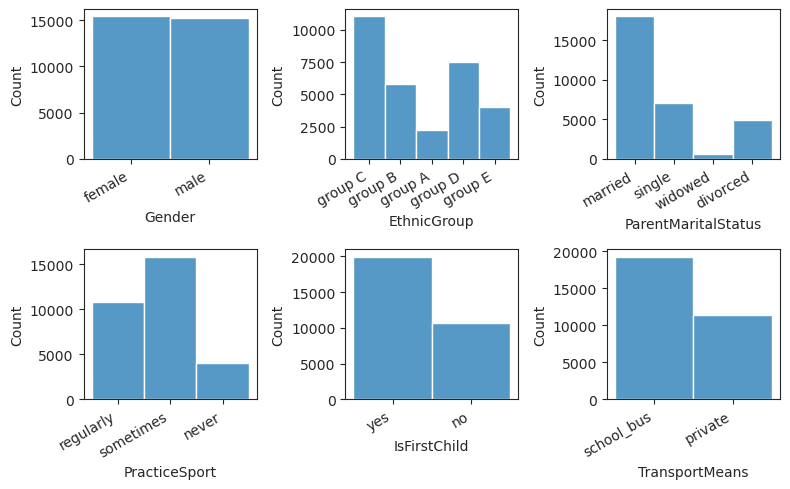

In [12]:
fig,ax = plt.subplots(nrows=2
                      ,ncols=3
                      ,figsize=(8,5))
ax = ax.flatten()
for k,col in enumerate(cols_categoric):
    labels = data_tags[col].unique()
    sns.histplot(data_tags[col],
                 bins=bins
                 ,kde=False
                 ,label=col
                 ,ax=ax[k])
    ax[k].set_xticklabels(labels=labels
                          ,rotation=30
                          ,ha='right')
plt.tight_layout()
plt.show()


### Clases ordinales

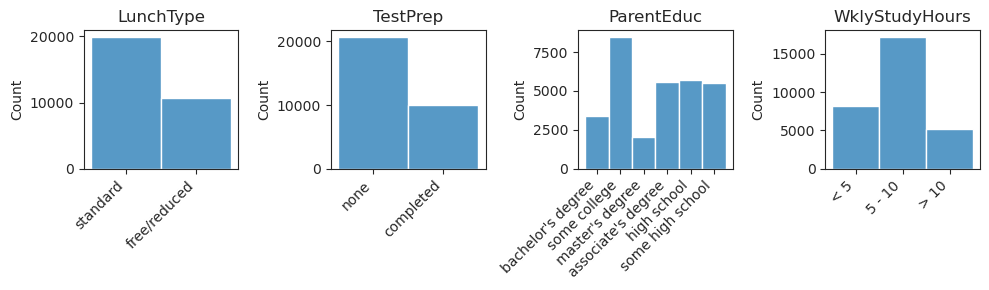

In [13]:
fig,ax = plt.subplots(nrows=1
                      ,ncols=4
                      ,figsize=(10,3))
ax = ax.flatten()
for k,col in enumerate(cols_ordinal):
    label=list(data_tags[col].unique())
    sns.histplot(data_tags[col],
                 bins=bins
                 ,kde=False
                 ,label=col
                 ,ax=ax[k])
    ax[k].xaxis.set_ticklabels(labels=label
                          ,rotation=45
                          , ha='right')
    ax[k].set_xlabel('')
    ax[k].set_title(col)
plt.tight_layout()
plt.show()

### Clases de Objetivo

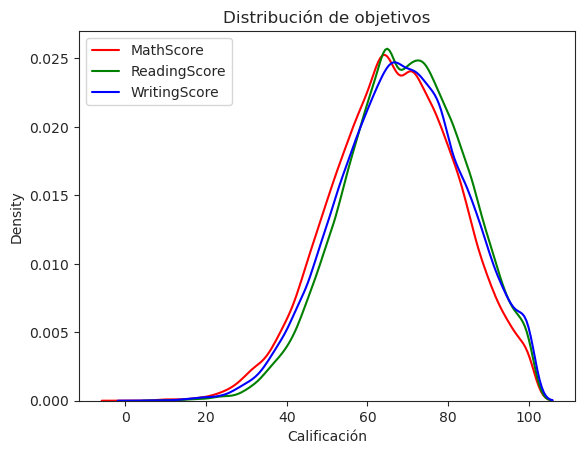

In [14]:
sns.kdeplot(data=data_tags,x='MathScore',label='MathScore',color='red')
sns.kdeplot(data=data_tags,x='ReadingScore',label='ReadingScore',color='green')
sns.kdeplot(data=data_tags,x='WritingScore',label='WritingScore',color='blue')
plt.legend()
plt.title('Distribución de objetivos')
plt.xlabel('Calificación')
plt.show()

Nótese que las clases **categóricas y ordinales se encuentran desbalanceadas**, sin embargo `Gender` es encuentra menos desbalanceada, de manera que resulta práctico usar dicha clase como contraste, tras balancearla con ***SMOTE***. En adición, las calificaciones están correlacionadas, como se muestra en el solapamiento de sus distribuciones, lo que tiene sentido.

In [15]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import EditedNearestNeighbours as ENN, TomekLinks as TMK
from imblearn.combine import SMOTEENN,SMOTETomek

In [16]:
def smooting (df_target:pd.DataFrame,df_vars:pd.DataFrame):
    #tmk = TMK(n_jobs=-1)
    smo = SMOTE(k_neighbors=2,n_jobs=-1)
    enn = ENN(n_neighbors=1)
    method = SMOTEENN(sampling_strategy='minority',n_jobs=-1,smote=smo,enn=enn,random_state=671)
    #method = SMOTETomek(sampling_strategy='minority',n_jobs=-1,smote=smo,tomek=tmk,random_state=345)
    #method = RandomOverSampler(sampling_strategy='not majority',random_state=42)
    method.fit(df_vars,df_target)
    df_vars_out, df_target_out = method.fit_resample(df_vars,df_target)
    return df_vars_out, df_target_out

In [17]:
from tqdm import tqdm

In [18]:
def balance(df_main:pd.DataFrame,cols:list):
    df_aux = df_main.copy()
    df_new = df_aux.copy()
    for col in tqdm(cols):
        df_aux = pd.concat(smooting(df_target=df_new[col],
                                    df_vars=df_new.drop(labels=col,axis=1)),axis=1)
        df_new = df_aux.copy()
        del(df_aux)
        print(df_new.shape)
    return df_new

In [19]:
cols_balance = ['Gender','EthnicGroup','LunchType','ParentEduc']

In [20]:
data_nb = balance(df_main=data,cols=cols_balance)

 25%|██▌       | 1/4 [00:01<00:03,  1.21s/it]

(28006, 14)


 50%|█████     | 2/4 [00:02<00:02,  1.34s/it]

(39038, 14)


 75%|███████▌  | 3/4 [00:03<00:01,  1.15s/it]

(39609, 14)


100%|██████████| 4/4 [00:05<00:00,  1.30s/it]

(56190, 14)


Si se elige muchas clases para balancear, la distribución de los objetivos se deteriora bruscamente; adicionalmente el tamaño del conjunto de datos puede crecer en varios órdenes de magnitud, de manera que altera demasiado las predicciones ya que las distribuciones de las demás clases ya balanceadas varían demasiado con respecto a las iniciales. 

In [21]:
data_nb.to_csv(path_or_buf="./data_over_filled.csv",sep=',',index=False)

### Clases categóricas balanceadas

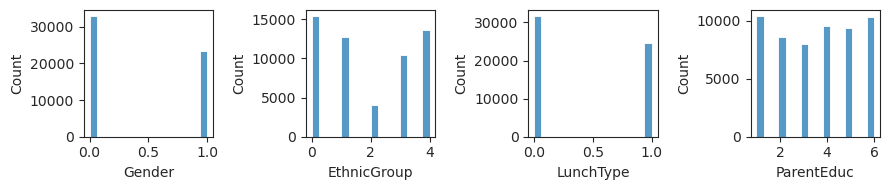

In [22]:
fig,ax = plt.subplots(nrows=1
                      ,ncols=4
                      ,figsize=(9,2))
ax = ax.flatten()
for k,col in enumerate(cols_balance):
    #labels = data_tags[col].unique()
    sns.histplot(data_nb[col],
                 bins=bins
                 ,kde=False
                 ,label=col
                 ,ax=ax[k])
    #ax[k].set_xticklabels(labels=labels
    #                      ,rotation=30
    #                      ,ha='right')
plt.tight_layout()
plt.show()


### Clases ordinales balanceadas

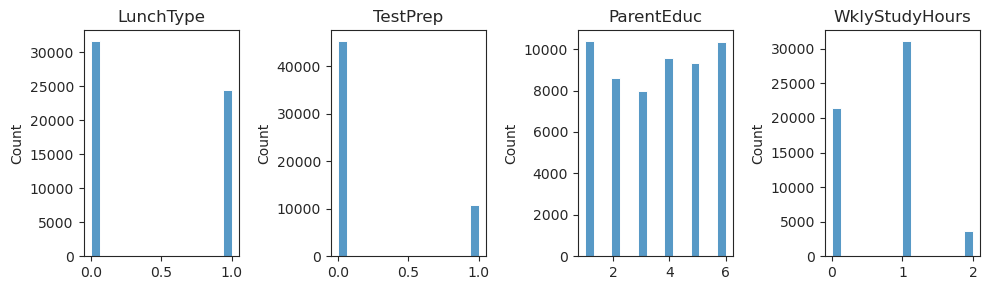

In [23]:
fig,ax = plt.subplots(nrows=1
                      ,ncols=4
                      ,figsize=(10,3))
ax = ax.flatten()
for k,col in enumerate(cols_ordinal):
    label=list(data_tags[col].unique())
    sns.histplot(data_nb[col],
                 bins=bins
                 ,kde=False
                 ,label=col
                 ,ax=ax[k])
    #ax[k].xaxis.set_ticklabels(labels=label
    #                      ,rotation=45
    #                      , ha='right')
    ax[k].set_xlabel('')
    ax[k].set_title(col)
plt.tight_layout()
plt.show()

In [24]:
data_nb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56190 entries, 0 to 56189
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   TestPrep             56190 non-null  int64  
 1   ParentMaritalStatus  56190 non-null  int64  
 2   PracticeSport        56190 non-null  int64  
 3   IsFirstChild         56190 non-null  int64  
 4   NrSiblings           56190 non-null  float64
 5   TransportMeans       56190 non-null  int64  
 6   WklyStudyHours       56190 non-null  int64  
 7   MathScore            56190 non-null  int64  
 8   ReadingScore         56190 non-null  int64  
 9   WritingScore         56190 non-null  int64  
 10  Gender               56190 non-null  int64  
 11  EthnicGroup          56190 non-null  int64  
 12  LunchType            56190 non-null  int64  
 13  ParentEduc           56190 non-null  int64  
dtypes: float64(1), int64(13)
memory usage: 6.0 MB


## <span style="color:rgb(0,200,200)">Distribución de objetivos de acuerdo a las demás clases</span>

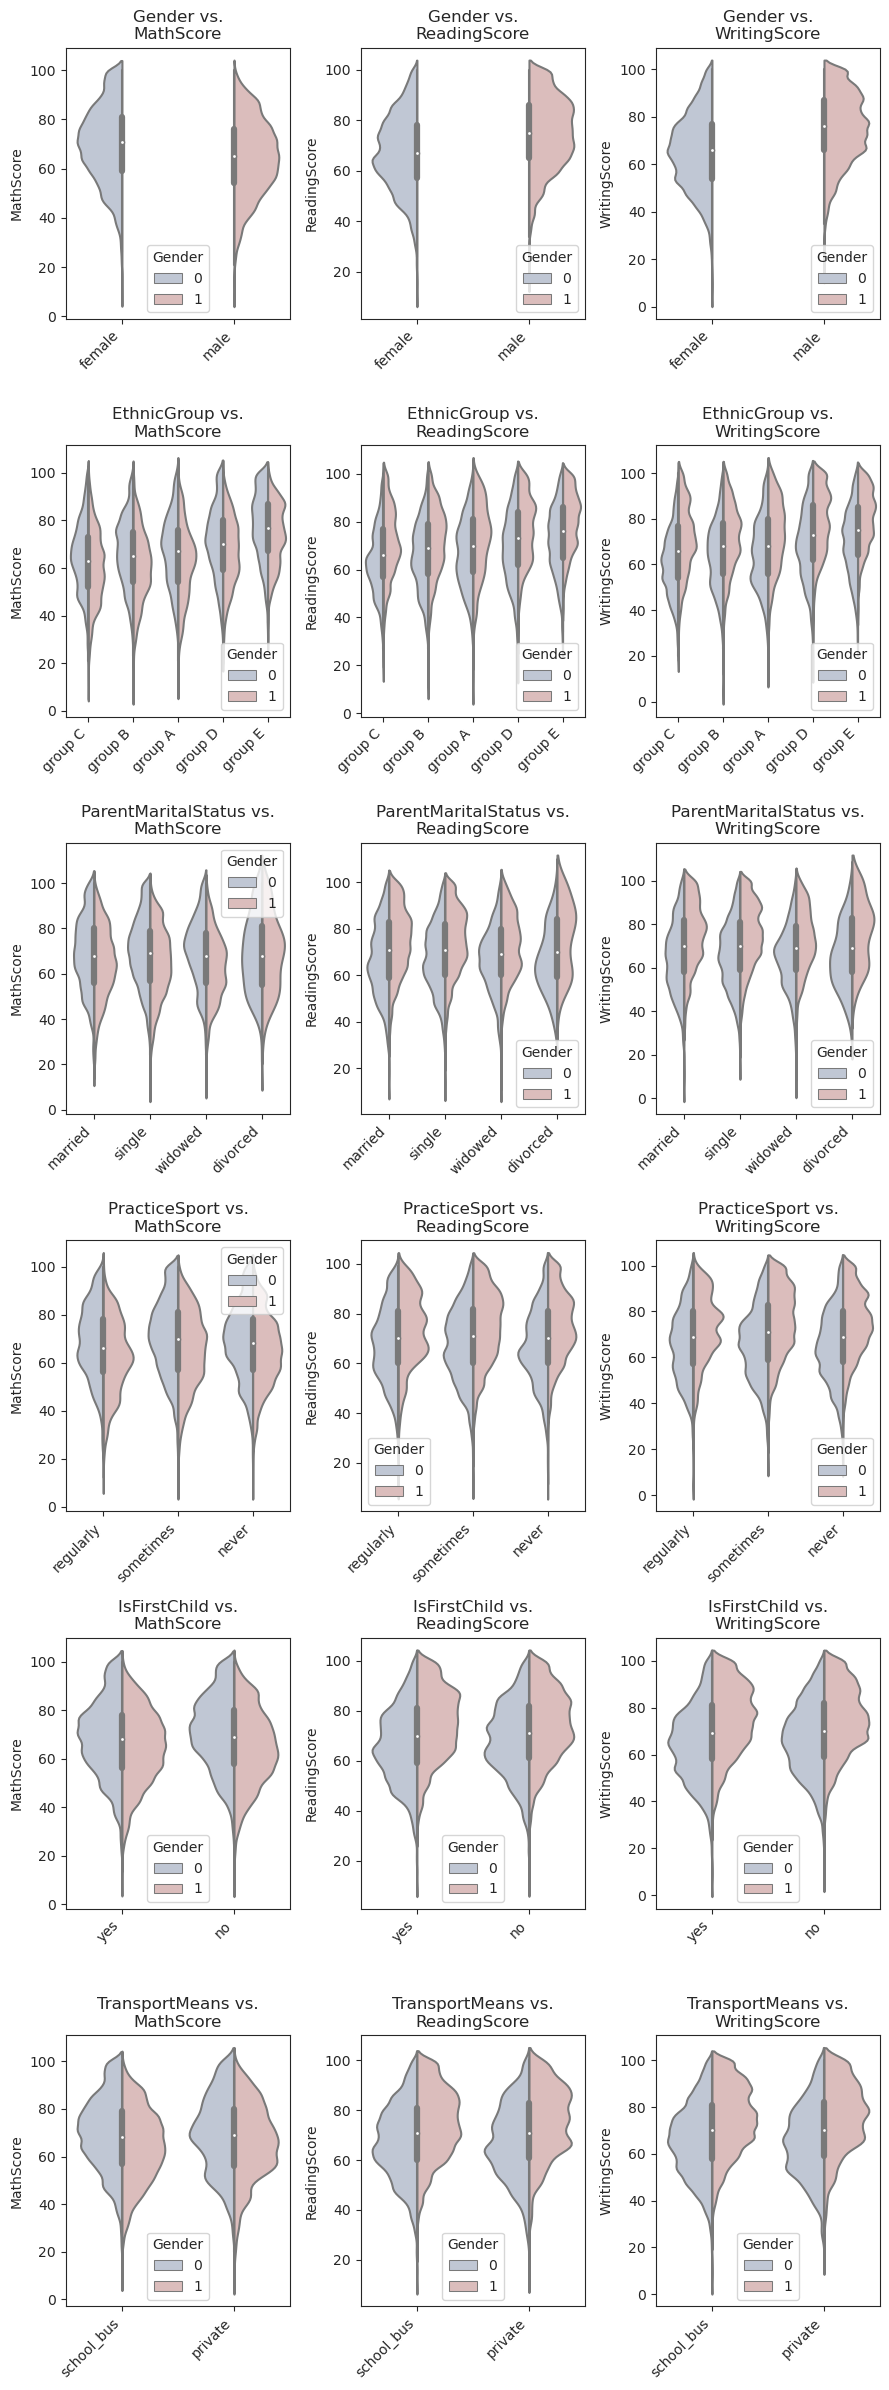

In [25]:
fig, axes = plt.subplots(nrows=6,ncols=3,figsize=(9,24))
for k,col in enumerate(cols_categoric):
    for l in range(3):
        labels = data_tags[col].unique()
        sns.violinplot(data=data_nb,x=col,y=cols_objective[l],hue='Gender',split=True,palette='vlag',ax=axes[k][l])
        axes[k][l].set_title(col+' vs.\n'+cols_objective[l])
        axes[k][l].xaxis.set_ticklabels(labels=labels
                          ,rotation=45
                          , ha='right')
        axes[k][l].set_xlabel('')
fig.set_tight_layout('tight')


### Clases Ordinales

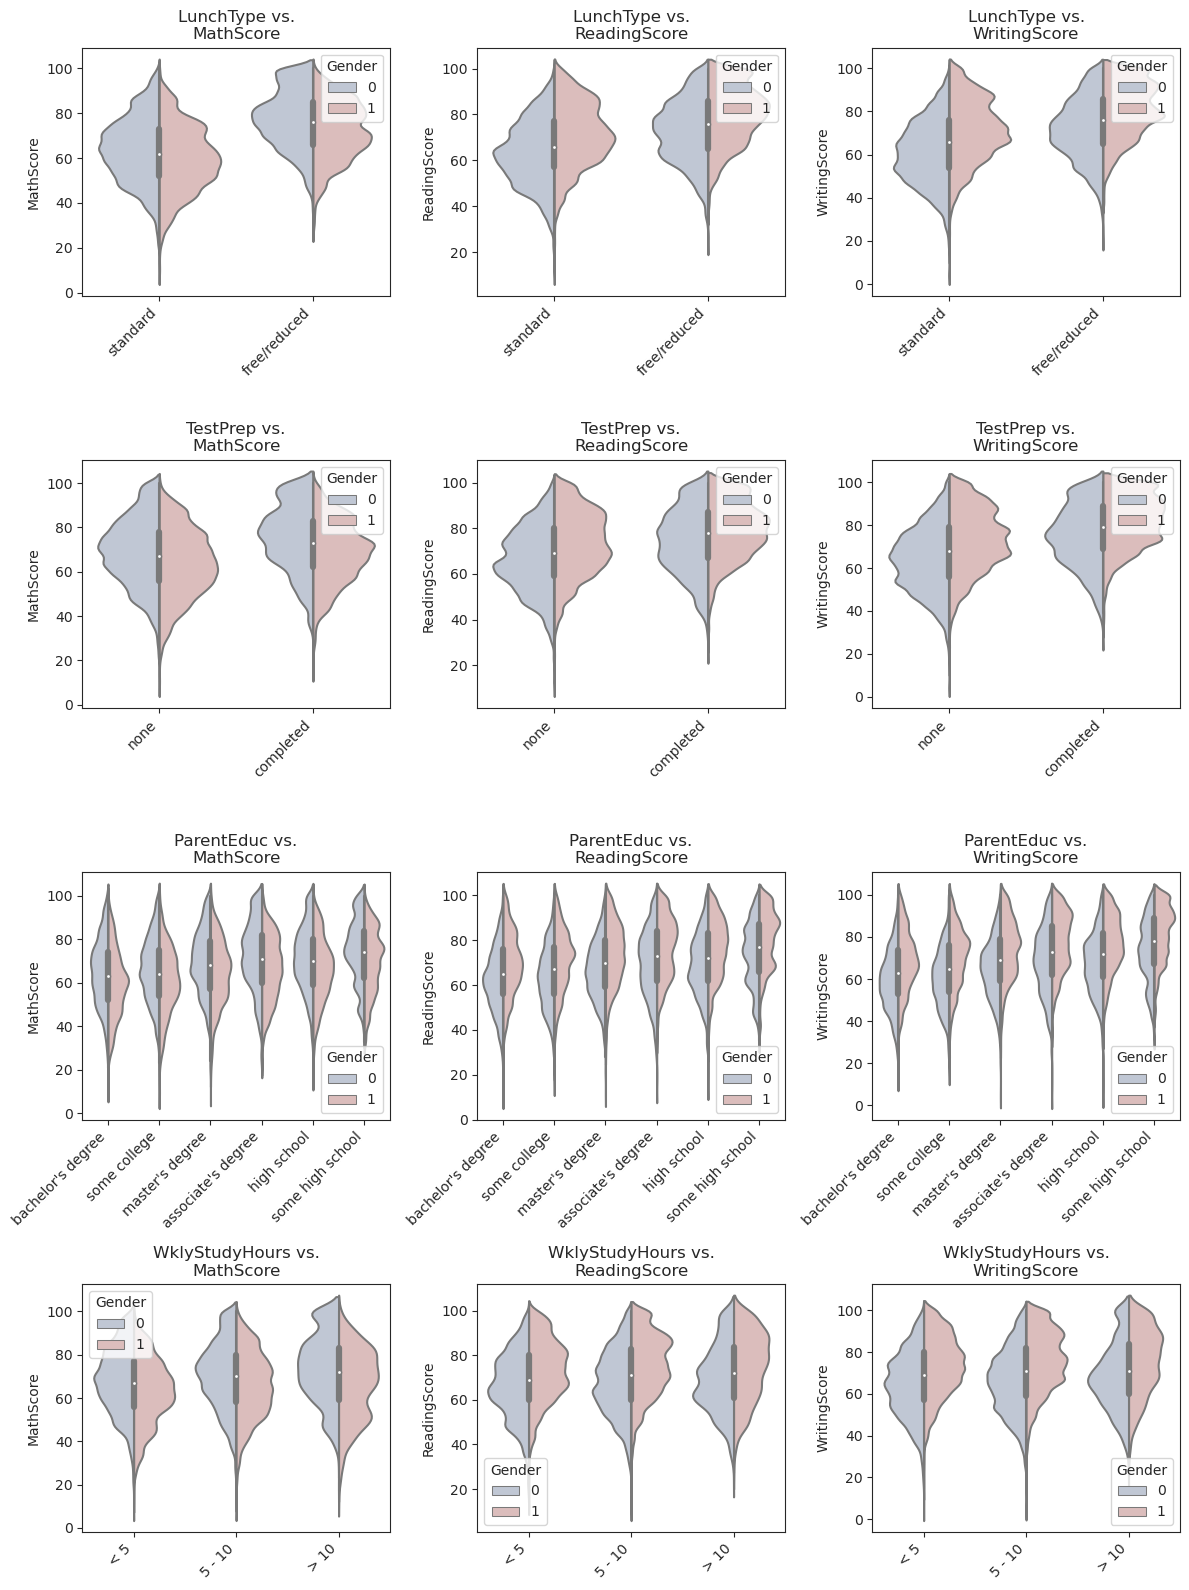

In [26]:
fig, axes = plt.subplots(nrows=4,ncols=3,figsize=(12,16))
for k,col in enumerate(cols_ordinal):
    for l in range(3):
        labels = data_tags[col].unique()
        sns.violinplot(data=data_nb,x=col,y=cols_objective[l],hue='Gender',split=True,palette='vlag',ax=axes[k][l])
        axes[k][l].set_title(col+' vs.\n'+cols_objective[l])
        axes[k][l].xaxis.set_ticklabels(labels=labels
                          ,rotation=45
                          , ha='right')
        axes[k][l].set_xlabel('')
fig.set_tight_layout('tight')

### Clases cuantitativas y objetivos

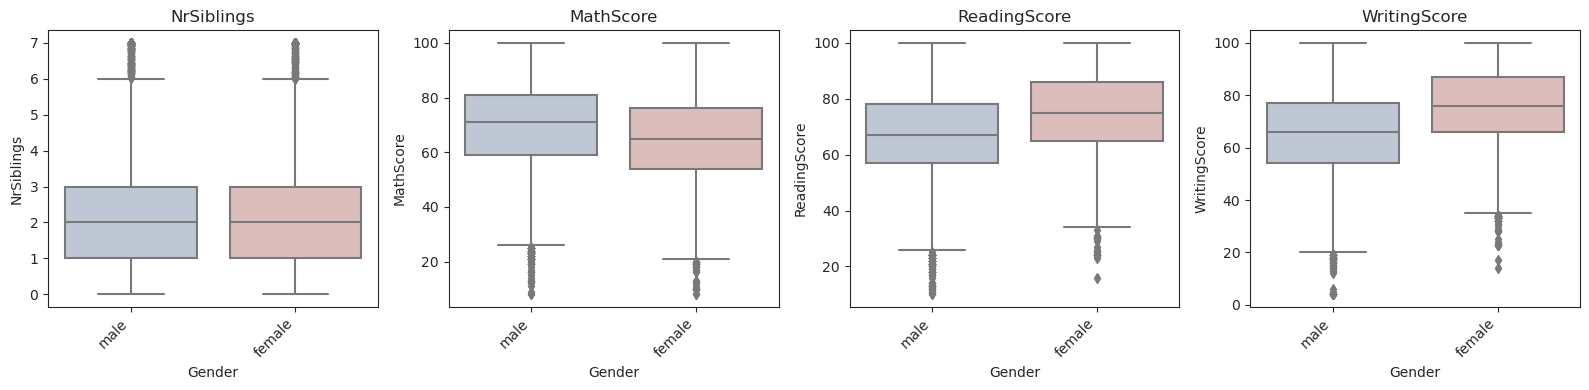

In [27]:
fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(16,4))
ax = ax.flatten()
for k,col in enumerate(cols_cuantitative):
    labels = ['male','female']
    sns.boxplot(data_nb,y=col,x='Gender',ax=ax[k],palette='vlag')
    ax[k].set_title(col)
    ax[k].xaxis.set_ticklabels(labels=labels
                                    ,rotation=45
                                    , ha='right')
plt.tight_layout()


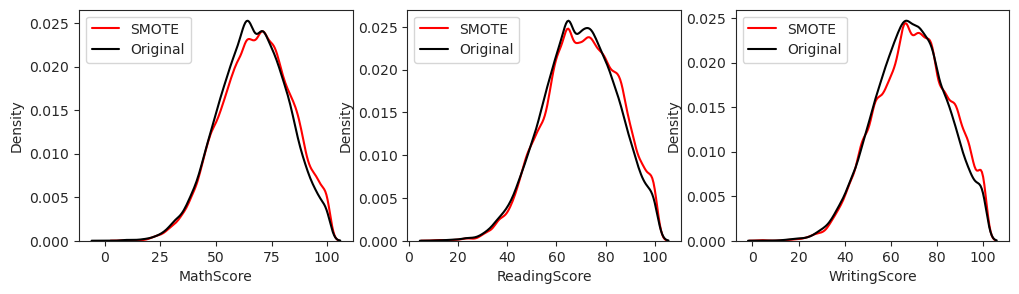

In [28]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
sns.kdeplot(data=data_nb,x='MathScore',label='SMOTE',color='red')
sns.kdeplot(data=data_tags,x='MathScore',label='Original',color='black')

plt.legend()

plt.subplot(1,3,2)
sns.kdeplot(data=data_nb,x='ReadingScore',label='SMOTE',color='red')
sns.kdeplot(data=data_tags,x='ReadingScore',label='Original',color='black')

plt.legend()

plt.subplot(1,3,3)
sns.kdeplot(data=data_nb,x='WritingScore',label='SMOTE',color='red')
sns.kdeplot(data=data_tags,x='WritingScore',label='Original',color='black')

plt.legend()

## Análisis

El patrón común de todas las clases es que: el valor más probables de calificaciones en `MathScore` es superior para el género `male`; por el contrario, la moda de calificaciones de los objetivos `ReadingScore` y `WritingScore`  son superiores para el género `female`.

En las clases socioeconómicas `ParentEduc` y `LunchType`, la moda de calificaciones en los 3 objetivos es más altas en los valores `master's_degree` y `standard`, respectivamente, sin importar el género. Por otro lado, la  clase académica `TestPrep` muestra el mismo comportamiento en el valor `completed`; mientras que, la clase `WklyStudyHours` parece no mostrar un incremento o decremento significativo en las calificaciones objetivo.

La media de calificaciones del los alumnos pertenecientes al grupo étnico `group E` son superiores a las calificaciones de los perteneicentes a otros grupos étnicos.

Lo anterior plantea la interrogante: ¿el comportamiento de los objetivos varía conforme se balancea las características mencionadas, ó no?

## <span style="color:rgb(0,200,200)">Correlación de los datos</span>

In [29]:
def corr_matrix (df:pd.DataFrame):
    fig,axes = plt.subplots(ncols=1,nrows=1,figsize=(20,10))
    
    corr = df.corr()
    sns.heatmap(data=corr,
                annot=True,
                fmt=".2f",
                annot_kws={"fontsize":10},
                cbar=True,
                cmap="vlag",
                linewidth=.5)
    plt.title("Matriz de Correlación")
    plt.show()

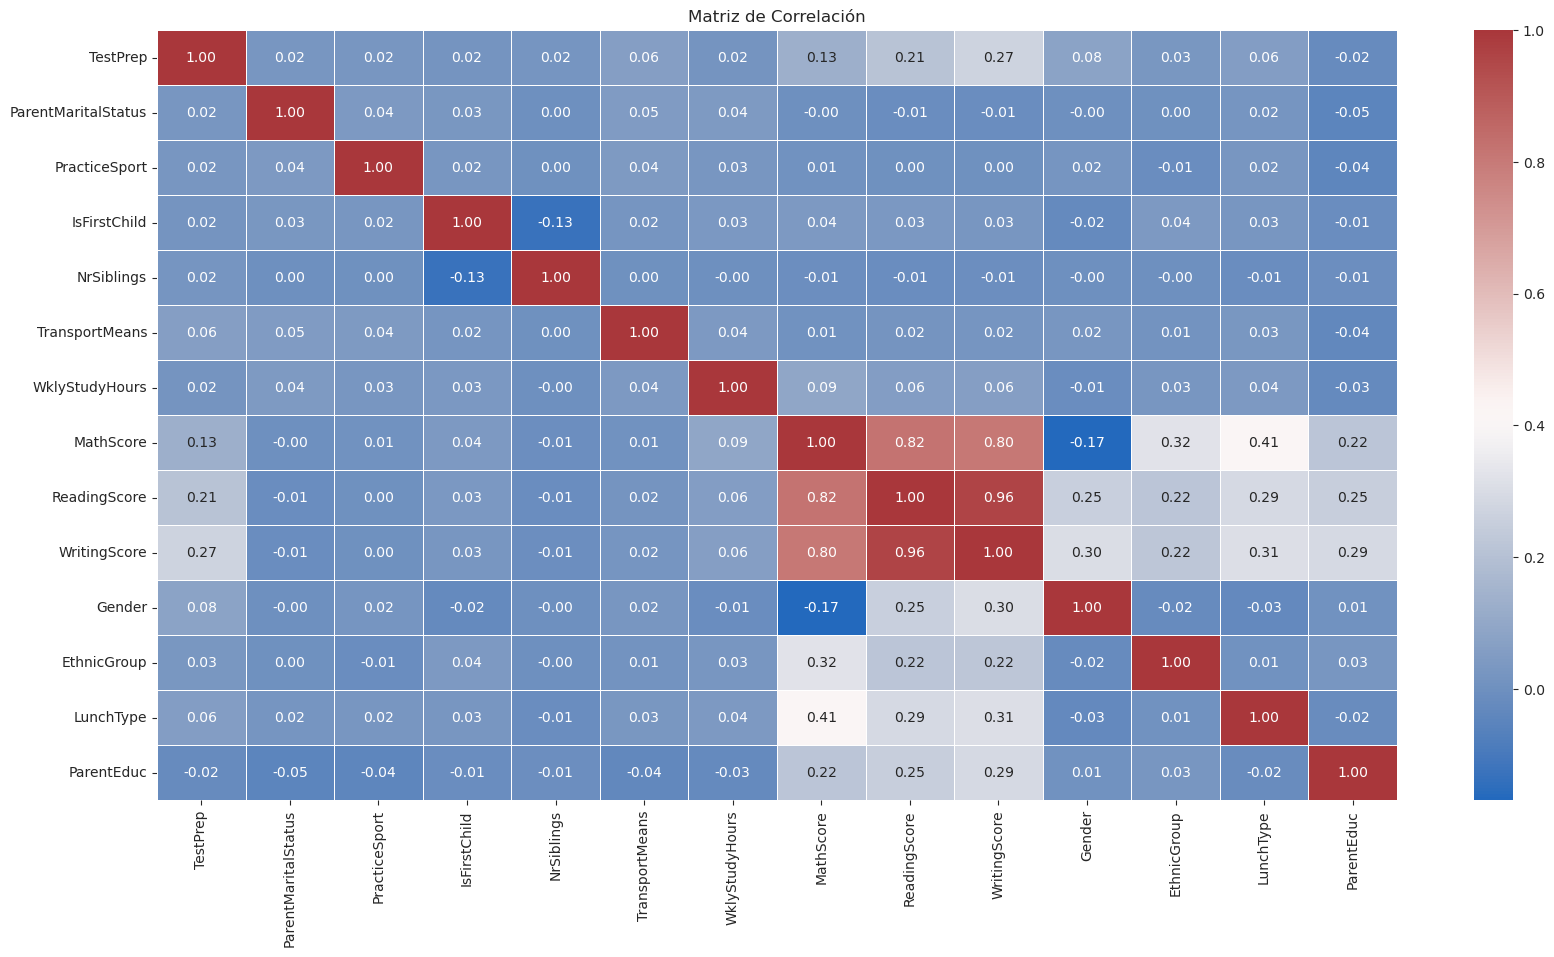

In [30]:
corr_matrix(data_nb)

De acuerdo a la matriz de correlación se puede notar que las clases más correlacioadas con los objetivos son:
1. `MathScore` -> `'LunchType','EthnicGroup','ParentEduc','TestPrep','Gender'`
2. `ReadingScore` -> `'LunchType','Gender','ParentEduc','TestPrep','EthnicGroup'`
3. `WritingScore` -> `'Gender','TestPrep','LunchType','ParentEduc','EthnicGroup'`

---
# <span style="color:rgb(180,200,0)">Selección de variables</span>

---

## <span style="color:rgb(0,200,200)">Con Scikit-Learn</span>

### importar los módulos de selección

se usará la métrica de $\chi^{2}$, Fisher para seleccionar las variables que más influyen se relacionan con el objetivo (las calificaciones)

In [31]:
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn.feature_selection import RFE # recursive feature elimination
from sklearn.ensemble import ExtraTreesClassifier,ExtraTreesRegressor 
n_classes=2

In [32]:
target = data[cols_objective]
variables = data.drop(cols_objective,axis=1)

## <span style="color:rgb(200,0,0)"> Select Kbest </span>

In [33]:
def clasif_kbest (df_target,df_train,crit,n_classes):
  df_target = pd.DataFrame(df_target)
  target_name = df_target.columns.values[0]
  df_train =pd.DataFrame(df_train)
  x,y = [np.array(df_train),(np.array(df_target.values.ravel()))]
  result = list()
  for method in crit:
    selector = SelectKBest(score_func=method,k=n_classes)
    atributes = selector.fit(x,y).get_support()
    atributos = [data.drop(cols_objective,axis=1).columns.values[i] for i in list(atributes.nonzero()[0])]
    result.append(atributos)
  result = np.array(result).flatten()
  result = pd.DataFrame({target_name:list(result)}).drop_duplicates()
  return list(np.array(result).flatten())


In [34]:
crit = [f_classif,chi2]
var_selected_kbest = list(range(3))
for k,targ in enumerate(cols_objective):
    var_selected_kbest[k] = clasif_kbest(target[targ],variables,crit=crit,n_classes=n_classes)
display(var_selected_kbest)

[['EthnicGroup', 'LunchType'],
 ['Gender', 'LunchType', 'TestPrep'],
 ['Gender', 'TestPrep']]

In [35]:
def clasif_trees (df_target,df_train,crit,n_classes):
  df_target = pd.DataFrame(df_target)
  target_name = df_target.columns.values[0]
  df_train =pd.DataFrame(df_train)
  x,y = [np.array(df_train),(np.array(df_target.values.ravel()))]
  result = list()
  for method in crit:
    model = ExtraTreesRegressor(criterion=method,n_jobs=ncpu())
    selector = RFE(estimator=model,n_features_to_select=n_classes)
    atributes = selector.fit(x,y).get_support()
    atributos = [variables.columns.values[i] for i in list(atributes.nonzero()[0])]
    result.append(atributos)
  result = np.array(result).flatten()
  result = pd.DataFrame({target_name:list(result)}).drop_duplicates()
  return list(np.array(result).flatten())

In [36]:
crit = ['poisson']
var_selected_trees = [0,0,0]
for k,targ in enumerate(cols_objective):
    var_selected_trees[k] = clasif_trees(target[targ],variables,crit=crit,n_classes=n_classes)
display(var_selected_trees)

[['EthnicGroup', 'LunchType'], ['Gender', 'LunchType'], ['Gender', 'TestPrep']]

In [37]:
def del_dup (df):
    aux = 'name'
    aux = pd.DataFrame({aux:list(df)}).drop_duplicates()
    return np.array(aux)

In [38]:
cols_selected=r_math,r_read,r_writ = [np.array(del_dup(var_selected_trees[k]+var_selected_kbest[k])).flatten() for k in range(3)]

In [39]:
cols_selected


[array(['EthnicGroup', 'LunchType'], dtype=object),
 array(['Gender', 'LunchType', 'TestPrep'], dtype=object),
 array(['Gender', 'TestPrep'], dtype=object)]

En ese sentido vamos a ver la correlación de las variables con lo que se busca predecir

In [40]:
cols_selected_list = list()
for k in range(3):
    for col in cols_selected[k]:
        cols_selected_list.append(col)
cols_selected_list = list(del_dup(cols_selected_list).flatten())
print(f"clases seleccionadas {cols_selected_list}")

clases seleccionadas ['EthnicGroup', 'LunchType', 'Gender', 'TestPrep']


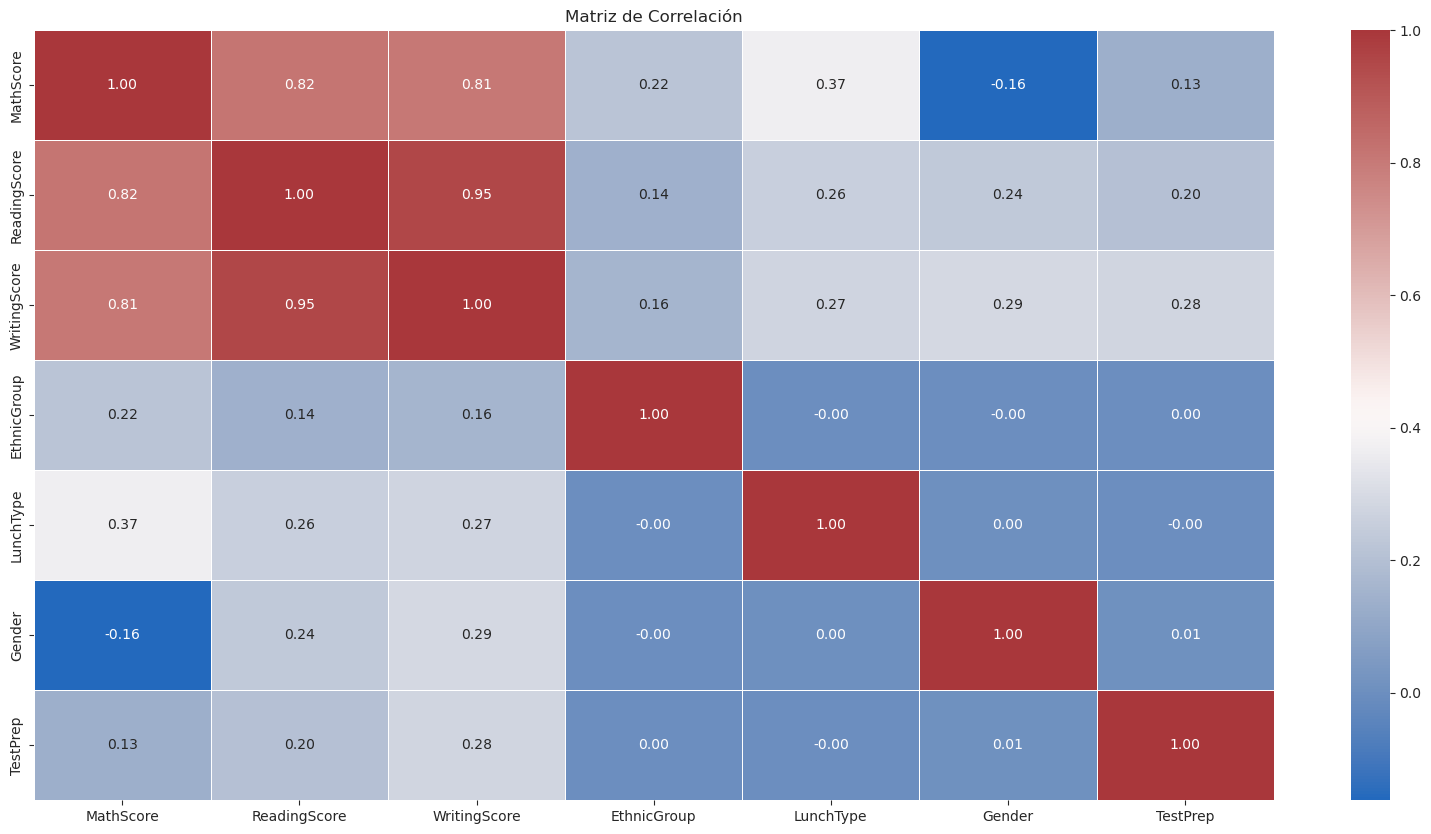

In [41]:

data_selected = data[list(cols_objective + cols_selected_list)]
corr_matrix(data_selected)
plt.show()

---
# <span style="color:rgb(180,200,0)">Implementación de modelos </span>

---
## Separar conjunto de variables relevantes

las variables relevantes que influyen en las características de las 3 calificaciones son:

`'LunchType', 'EthnicGroup', 'Gender', 'TestPrep'`

In [42]:
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.metrics import accuracy_score

### Separar dataset

In [43]:
bins = round(1+np.log2(data.shape[0]))

x = np.array(data_nb[cols_selected_list])
#x = data_nb.drop(cols_objective,axis=1)

#y = np.array(data_nb['MathScore']).reshape(-1,1)
y = np.array(data_nb[cols_objective])

x_train,x_test,y_train,y_test = split(x,y,train_size=.7)
y_train = y_train.transpose()
y_test = y_test.transpose()

# -------------------------------------------------------

x_np = np.array(data[cols_selected_list]) # x no preprocesada

y_np = np.array(data[cols_objective]) # y no preprocesada

x_train_np,x_test_np,y_train_np,y_test_np = split(x_np,y_np,train_size=.7,random_state=46)
y_train_np = y_train_np.transpose()
y_test_np = y_test_np.transpose()


In [44]:
y_test_np.shape

(3, 9193)

## Regresión lineal

In [45]:
from sklearn.linear_model import LinearRegression

In [46]:
linear_scores = list()
y_predicted = []
for k,col in enumerate(cols_objective):
    y_tr = y_train[k]
    y_te = y_test[k]
    
    regresor = LinearRegression(n_jobs=-1)
    result = regresor.fit(x_train,y_tr)
    y_predicted.append(result.predict(x_test))
    y_pred = y_predicted[k]
    y_tr_pred = result.predict(x_train)
    
    print(f"\n--- {col} ---\n")

    metrics = [r2_score(y_tr,y_tr_pred),
               r2_score(y_true=y_te,y_pred=y_pred),
               mean_squared_error(y_true=y_te,y_pred=y_pred),
               mean_absolute_error(y_true=y_te,y_pred=y_pred)]
    print(f"r2 entreno = {metrics[0]}")
    print(f"r2 prueba= {metrics[1]}")
    print(f"mse prueba = {metrics[2]}")
    print(f"mae prueba = {metrics[3]}")
    linear_scores.append({'linear_'+col:metrics})


--- MathScore ---

r2 entreno = 0.31313712518617154
r2 prueba= 0.30215194990081184
mse prueba = 170.9641926969995
mae prueba = 10.618614573694344

--- ReadingScore ---

r2 entreno = 0.23366634173706968
r2 prueba= 0.21846860788402578
mse prueba = 174.4106874197551
mae prueba = 10.787031835889357

--- WritingScore ---

r2 entreno = 0.29753343478841965
r2 prueba= 0.28145781749810517
mse prueba = 179.2767443365877
mae prueba = 10.924641154884299


La mayor precisión la alcanzó `MathScore` con $r^2\approx0.295$

La menor precisión fue de `ReadingScore` con $r^2\approx0.224$

In [47]:
data_nb.shape


(56190, 14)

### <span style="color:rgb(200,0,200)">NO SMOOTEEN</span>

In [48]:
linear_scores_np = []
y_predicted_np = []
for k,col in enumerate(cols_objective):
    y_tr_np = y_train_np[k]
    y_te_np = y_test_np[k]
    
    regresor = LinearRegression(n_jobs=-1)
    result = regresor.fit(x_train_np,y_tr_np)
    y_predicted_np.append(result.predict(x_test_np))
    y_pred_np = y_predicted_np[k]
    y_tr_pred_np = result.predict(x_train_np)
    
    print(f"\n--- {col} ---\n")

    metrics_np = [r2_score(y_tr_np,y_tr_pred_np),
               r2_score(y_true=y_te_np,y_pred=y_pred_np),
               mean_squared_error(y_true=y_te_np,y_pred=y_pred_np),
               mean_absolute_error(y_true=y_te_np,y_pred=y_pred_np)]
    print(f"r2 entreno = {metrics_np[0]}")
    print(f"r2 prueba= {metrics_np[1]}")
    print(f"mse prueba = {metrics_np[2]}")
    print(f"mae prueba = {metrics_np[3]}")
    linear_scores_np.append({'linear_'+col+'_raw':metrics_np})



--- MathScore ---

r2 entreno = 0.22294039769808482
r2 prueba= 0.23863667713173375
mse prueba = 180.9723466053401
mae prueba = 10.892792102743943

--- ReadingScore ---

r2 entreno = 0.18293907494102468
r2 prueba= 0.18556926002955065
mse prueba = 177.42754849577716
mae prueba = 10.803517003495815

--- WritingScore ---

r2 entreno = 0.2598116326858029
r2 prueba= 0.2660539735846956
mse prueba = 174.56349235548493
mae prueba = 10.72301772859878


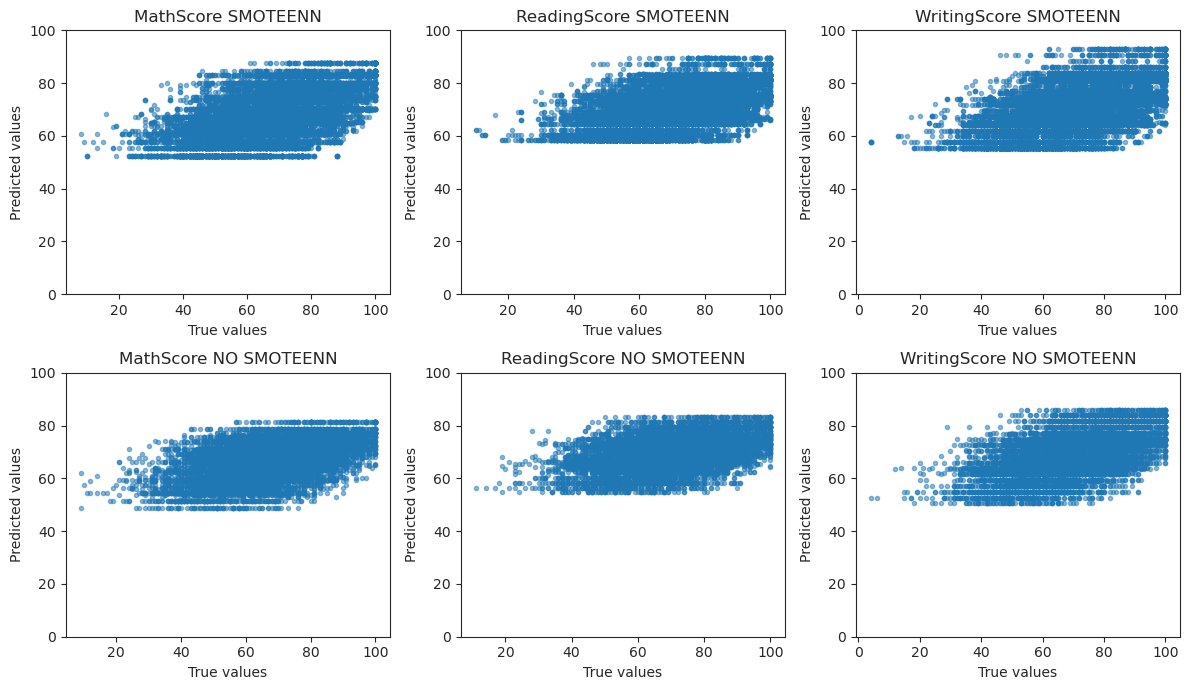

In [49]:
fig,axs = plt.subplots(ncols=3,nrows=2,figsize=(12,7))

for k,col in enumerate(cols_objective):
    axs[0][k].scatter(y_test[k],y_predicted[k],alpha=.5,marker='.')
    axs[0][k].set_title(col+' SMOTEENN')
    axs[0][k].set_ylim([0,100])
    axs[0][k].set_xlabel("True values")
    axs[0][k].set_ylabel("Predicted values")

    axs[1][k].scatter(y_test_np[k],y_predicted_np[k],alpha=.5,marker='.')
    axs[1][k].set_title(col+' NO SMOTEENN')
    axs[1][k].set_ylim([0,100])
    axs[1][k].set_xlabel("True values")
    axs[1][k].set_ylabel("Predicted values")
fig.set_tight_layout(tight=True)

## K-vecinos

In [50]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
n_neighbors = int (1e3)

In [51]:
neighbors_scores = list()
y_predicted_np = []
for k,col in enumerate(cols_objective):
    y_tr = y_train[k]
    y_te = y_test[k]
    
    print(f"\n--- {col} ---")

    knn = KNeighborsRegressor(n_neighbors=n_neighbors,weights='distance',n_jobs=-1)
    knn.fit(x_train,y_tr)
    y_predicted.append(result.predict(x_test))
    y_pred = y_predicted[k]
    y_tr_pred = knn.predict(x_train)

    print(f"\nprecisión en entreno {knn.score(x_train,y_tr):1.3f}")
    print(f"precisión en prueba {knn.score(x_test,y_te):1.3f}\n")
    
    metrics = [r2_score(y_tr,y_tr_pred),
                r2_score(y_true=y_te,y_pred=y_pred),
                mean_squared_error(y_true=y_te,y_pred=y_pred),
                mean_absolute_error(y_true=y_te,y_pred=y_pred)]
    print(f"r2 entreno = {metrics[0]}")
    print(f"r2 prueba= {metrics[1]}")
    print(f"mse prueba = {metrics[2]}")
    print(f"mae prueba = {metrics[3]}")
    neighbors_scores.append({'neighbors_'+col+'SMOTEENN':metrics})


--- MathScore ---

precisión en entreno 0.329
precisión en prueba 0.315

r2 entreno = 0.32897381596496167
r2 prueba= 0.30215194990081184
mse prueba = 170.9641926969995
mae prueba = 10.618614573694344

--- ReadingScore ---

precisión en entreno 0.242
precisión en prueba 0.224

r2 entreno = 0.24152365895321626
r2 prueba= 0.21846860788402578
mse prueba = 174.4106874197551
mae prueba = 10.787031835889357

--- WritingScore ---

precisión en entreno 0.305
precisión en prueba 0.287

r2 entreno = 0.3046632337281173
r2 prueba= 0.28145781749810517
mse prueba = 179.2767443365877
mae prueba = 10.924641154884299


### <span style="color:rgb(200,0,200)"> NO SMOTEENN</span>

In [52]:
neighbors_scores_np = list()
y_predicted_np = []
for k,col in enumerate(cols_objective):
    y_tr_np = y_train_np[k]
    y_te_np = y_test_np[k]
    
    print(f"\n--- {col} ---")
    
    knn = KNeighborsRegressor(n_neighbors=n_neighbors,weights='distance',n_jobs=-1)
    knn.fit(x_train_np,y_tr_np)
    y_predicted_np.append(result.predict(x_test_np))
    y_pred_np = y_predicted_np[k]
    y_tr_pred_np = knn.predict(x_train_np)

    print(f"\nprecisión en entreno {knn.score(x_train_np,y_tr_np):1.3f}")
    print(f"precisión en prueba {knn.score(x_test_np,y_te_np):1.3f}\n")
    
    metrics = [r2_score(y_tr_np,y_tr_pred_np),
                r2_score(y_true=y_te_np,y_pred=y_pred_np),
                mean_squared_error(y_true=y_te_np,y_pred=y_pred_np),
                mean_absolute_error(y_true=y_te_np,y_pred=y_pred_np)]
    print(f"r2 entreno = {metrics[0]}")
    print(f"r2 prueba= {metrics[1]}")
    print(f"mse prueba = {metrics[2]}")
    print(f"mae prueba = {metrics[3]}")
    neighbors_scores_np.append({'neighbors_'+col+'_raw':metrics})


--- MathScore ---

precisión en entreno 0.238
precisión en prueba 0.249

r2 entreno = 0.2376922284956844
r2 prueba= -0.02460837021985096
mse prueba = 243.5444097984774
mae prueba = 12.563262505906504

--- ReadingScore ---

precisión en entreno 0.187
precisión en prueba 0.187

r2 entreno = 0.18700085682242495
r2 prueba= 0.16760982862589036
mse prueba = 181.34009468287854
mae prueba = 10.896770062723688

--- WritingScore ---

precisión en entreno 0.264
precisión en prueba 0.267

r2 entreno = 0.263705377946299
r2 prueba= 0.2660539735846956
mse prueba = 174.56349235548493
mae prueba = 10.72301772859878


## <span style="color:rgb(255,0,0)">¿porqué sale un $r^2$ <0?</span>

Como $r^2$ está definido como $$r^2\,=\,{\Large1}-{\sum_k (y_{true}^{(k)}-y_{pred}^{(k)})^2\over\sum_l(y_{pred}^{(l)} - \bar{y}_{true})^2}$$, el cociente que resta la unidad muestra que $$\sum_k (y_{true}^{(k)}-y_{pred}^{(k)})^2 \,>\, \sum_l(y_{pred}^{(l)} - \bar{y}_{true})^2$$; en otras palabras, la correlación entre los resultados predichos y los verdaderos, de la base de datos**sin preprocesar**, es baja (como si fueran "aleatorios")

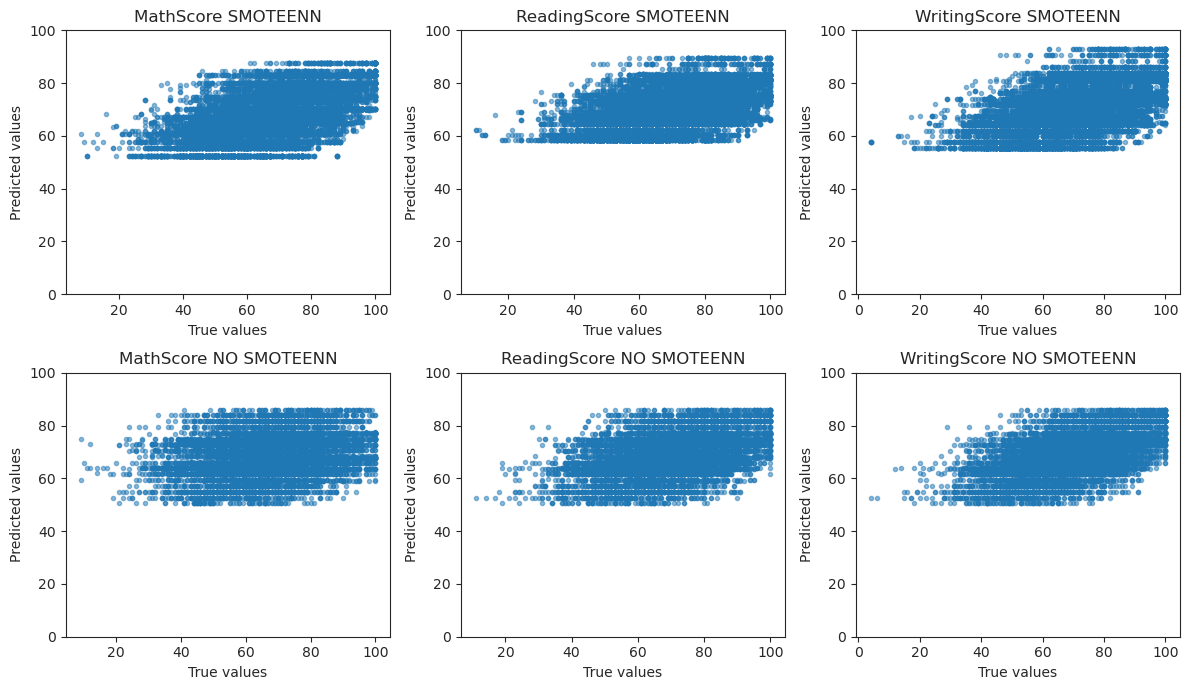

In [53]:
fig,axs = plt.subplots(ncols=3,nrows=2,figsize=(12,7))

for k,col in enumerate(cols_objective):
    axs[0][k].scatter(y_test[k],y_predicted[k],alpha=.5,marker='.')
    axs[0][k].set_title(col+' SMOTEENN')
    axs[0][k].set_ylim([0,100])
    axs[0][k].set_xlabel("True values")
    axs[0][k].set_ylabel("Predicted values")

    axs[1][k].scatter(y_test_np[k],y_predicted_np[k],alpha=.5,marker='.')
    axs[1][k].set_title(col+' NO SMOTEENN')
    axs[1][k].set_ylim([0,100])
    axs[1][k].set_xlabel("True values")
    axs[1][k].set_ylabel("Predicted values")
fig.set_tight_layout(tight=True)

al ver la gráfica de los datos `sin SMOTE` para `MathScore`  se puede coprobar cualitativamente que la distribución de predicciones para valores de testeo inferiores a 60 es `normal`. Lo anterior refuerza la idea de que no existe una buena correlación entre las predicciones echas al entrenar el modelo con los datos sin SMOTE (tampoco con SMOTE pero al menos mejora)

## Árboles de decisión

In [55]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [56]:
trees_scores = list()
y_predicted = []
for k,col in enumerate(cols_objective):
    y_tr = y_train[k]
    y_te = y_test[k]
    
    clf = DecisionTreeRegressor(random_state=42)
    param_grid = {'criterion': ['poisson'], 'max_depth': [10]}
    grid_search = GridSearchCV(clf, param_grid=param_grid, cv=10, return_train_score=True, n_jobs=-1)
    grid_search.fit(x_train, y_tr)

    print(f"\n--- {col} ---\n")

    print(f"Mejores hiperparámetros encontrados: {grid_search.best_params_}")
    print(f"Mejor puntuación de validación cruzada: {grid_search.best_score_}\n")

    best_clf = grid_search.best_estimator_
    y_tr_pred = best_clf.predict(x_train)
    
    y_pred = best_clf.predict(x_test)
    y_predicted.append(y_pred)

    metrics = [r2_score(y_tr,y_tr_pred),
               r2_score(y_true=y_te,y_pred=y_pred),
               mean_squared_error(y_true=y_te,y_pred=y_pred),
               mean_absolute_error(y_true=y_te,y_pred=y_pred)]
    print(f"r2 entreno = {metrics[0]}")
    print(f"r2 prueba= {metrics[1]}")
    print(f"mse prueba = {metrics[2]}")
    print(f"mae prueba = {metrics[3]}")
    trees_scores.append({col:metrics})


--- MathScore ---

Mejores hiperparámetros encontrados: {'criterion': 'poisson', 'max_depth': 10}
Mejor puntuación de validación cruzada: 0.32729646468937035

r2 entreno = 0.3290900430624607
r2 prueba= 0.3151634067955046
mse prueba = 167.77654572500214
mae prueba = 10.545365960532589

--- ReadingScore ---

Mejores hiperparámetros encontrados: {'criterion': 'poisson', 'max_depth': 10}
Mejor puntuación de validación cruzada: 0.23972405848020992

r2 entreno = 0.24175061942335263
r2 prueba= 0.2241870206108897
mse prueba = 173.13453612922035
mae prueba = 10.763484536591307

--- WritingScore ---

Mejores hiperparámetros encontrados: {'criterion': 'poisson', 'max_depth': 10}
Mejor puntuación de validación cruzada: 0.30297848692809903

r2 entreno = 0.3048669265738262
r2 prueba= 0.28683958170298973
mse prueba = 177.93399064872565
mae prueba = 10.889744858148864


### <span style="color:rgb(200,0,200)">NO SMOOTEENN</span>

In [57]:
trees_scores_np = list()

y_predicted_np = []
for k,col in enumerate(cols_objective):
    y_tr_np = y_train_np[k]
    y_te_np = y_test_np[k]
    
    clf = DecisionTreeRegressor(random_state=42)
    param_grid = {'criterion': ['poisson'], 'max_depth': [10]}
    grid_search = GridSearchCV(clf, param_grid=param_grid, cv=10, return_train_score=True, n_jobs=-1)
    grid_search.fit(x_train_np, y_tr_np)

    print(f"\n--- {col} ---\n")

    print(f"Mejores hiperparámetros encontrados: {grid_search.best_params_}")
    print(f"Mejor puntuación de validación cruzada: {grid_search.best_score_}\n")

    best_clf = grid_search.best_estimator_
    y_tr_pred_np = best_clf.predict(x_train_np)
    
    y_pred_np = best_clf.predict(x_test_np)
    y_predicted_np.append(y_pred_np)

    metrics = [r2_score(y_tr_np,y_tr_pred_np),
               r2_score(y_true=y_te_np,y_pred=y_pred_np),
               mean_squared_error(y_true=y_te_np,y_pred=y_pred_np),
               mean_absolute_error(y_true=y_te_np,y_pred=y_pred_np)]
    print(f"r2 entreno = {metrics[0]}")
    print(f"r2 prueba= {metrics[1]}")
    print(f"mse prueba = {metrics[2]}")
    print(f"mae prueba = {metrics[3]}")
    trees_scores_np.append({col:metrics})


--- MathScore ---

Mejores hiperparámetros encontrados: {'criterion': 'poisson', 'max_depth': 10}
Mejor puntuación de validación cruzada: 0.23395456362780104

r2 entreno = 0.23770620571924972
r2 prueba= 0.24894381841401314
mse prueba = 178.52238941851405
mae prueba = 10.828746023481159

--- ReadingScore ---

Mejores hiperparámetros encontrados: {'criterion': 'poisson', 'max_depth': 10}
Mejor puntuación de validación cruzada: 0.18326807192189676

r2 entreno = 0.1870060667950495
r2 prueba= 0.18701583068003658
mse prueba = 177.11240630916106
mae prueba = 10.801109376384805

--- WritingScore ---

Mejores hiperparámetros encontrados: {'criterion': 'poisson', 'max_depth': 10}
Mejor puntuación de validación cruzada: 0.2602980334807379

r2 entreno = 0.2637130648600867
r2 prueba= 0.2667946077900014
mse prueba = 174.38733813053793
mae prueba = 10.719520646751736


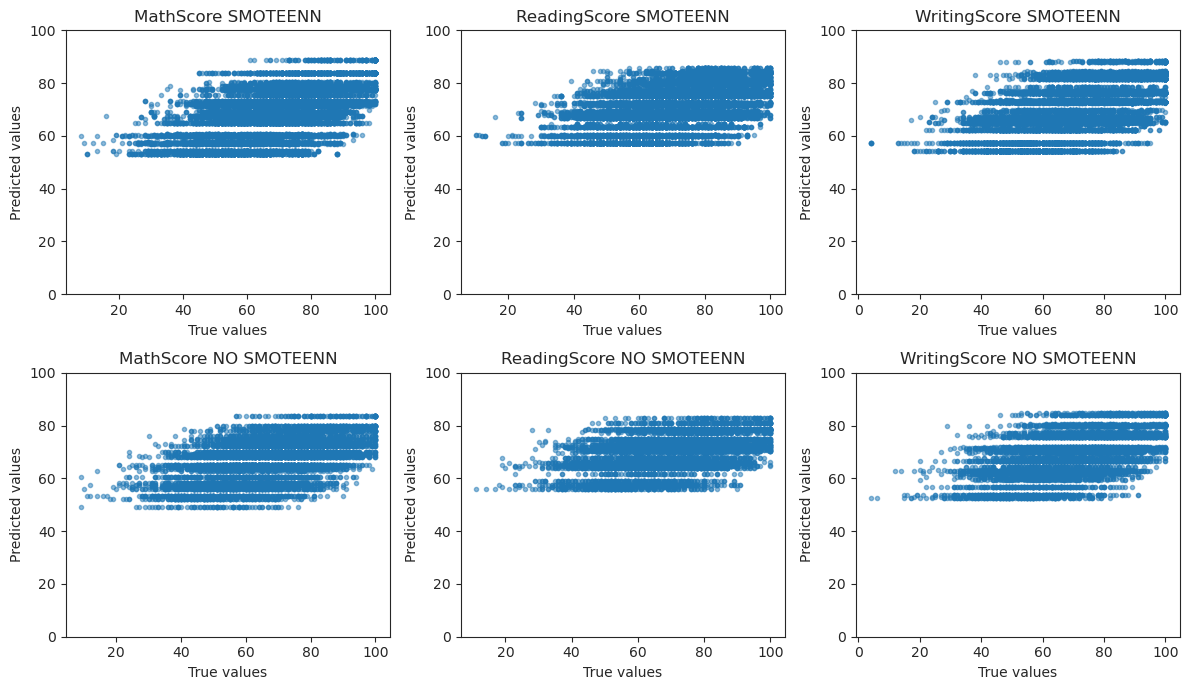

In [58]:
fig,axs = plt.subplots(ncols=3,nrows=2,figsize=(12,7))

for k,col in enumerate(cols_objective):
    axs[0][k].scatter(y_test[k],y_predicted[k],alpha=.5,marker='.')
    axs[0][k].set_title(col+' SMOTEENN')
    axs[0][k].set_ylim([0,100])
    axs[0][k].set_xlabel("True values")
    axs[0][k].set_ylabel("Predicted values")

    axs[1][k].scatter(y_test_np[k],y_predicted_np[k],alpha=.5,marker='.')
    axs[1][k].set_title(col+' NO SMOTEENN')
    axs[1][k].set_ylim([0,100])
    axs[1][k].set_xlabel("True values")
    axs[1][k].set_ylabel("Predicted values")
fig.set_tight_layout(tight=True)

---
### con los demás métodos (SVM, Neural Networks) el computador se quedó sin memoria ram o duró mucho tiempo (horas) sin respuesta.

---

# Tabla de conclusiones 

In [59]:
results= lin_res, nei_res, tre_res = [[linear_scores,linear_scores_np],
                                      [neighbors_scores,neighbors_scores_np],
                                      [trees_scores,trees_scores_np]]

In [60]:
r2_lin_sm = np.array([list(linear_scores[col].values())[0][1] for col in range(3)])
r2_lin_rw = np.array([list(linear_scores_np[col].values())[0][1] for col in range(3)])

r2_nei_sm = np.array([list(neighbors_scores[col].values())[0][1] for col in range(3)])
r2_nei_rw = np.array([list(neighbors_scores_np[col].values())[0][1] for col in range(3)])

r2_tre_sm = np.array([list(trees_scores[col].values())[0][1] for col in range(3)])
r2_tre_rw = np.array([list(trees_scores_np[col].values())[0][1] for col in range(3)])


In [61]:
r2_sm = [r2_lin_sm,r2_nei_sm,r2_tre_sm]
r2_rw = [r2_lin_rw,r2_nei_rw,r2_tre_rw]

## Error relativo  entre los resultados

Bajo la hipóteis de que la correlación mejora con SMOTEENN; entonces, el error relativo positivo indica una mejor correlación respecto a la correlación del modelo sin balance.

In [62]:
relative_error = np.array([100 * (r2_sm[method] - r2_rw[method])/r2_rw[method] for method in range(3)]).transpose()

In [63]:
pd.DataFrame(relative_error,columns=['linear','neighbors','trees'],index=cols_objective)

,linear,neighbors,trees
MathScore,26.615889,-1327.842182,26.600214
ReadingScore,17.728878,30.343554,19.875959
WritingScore,5.789744,5.789744,7.513261


El resultado feo de `MathScore` en el modelo de `k-neighbors` está relacionado con el $r^2<0$ que se discutió arriba, lo que prueba este resultado es que no vale la pena usar k-vecinos en un conjunto de datos poco correlacionado. en los demás casos le mejoría existe, no es la mejor, pero la hay. De manera que vale la pena hacer el balanceo de clases para mostrar la correlaciṕon de los adtos de una mejor manera.

El modelo lineal resultó aumentar la correlación de los datos de forma similiar al de áboles de desición. Por otro lado el modelo de k-vecinos destaca por su mejoría en `Reading Score` como la máxima mejoría con base al modelo; por último, `Writing Score` mostró un aumento menor al 10% en la correlación de las predicciones y los resultados por causa de la escogencia del modelo